In [1]:
import wobble
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.minor.size'] = 3

In [3]:
MODEL_T_COLOR = '#1f77b4'
MODEL_STAR_COLOR = '#d62728'
DATA_COLOR = 'k'
COLOR3 = '#7A68A6'

In [4]:
speed_of_light = 2.99792458e8   # m/s

def doppler(v):
    frac = (1. - v/speed_of_light) / (1. + v/speed_of_light)
    return np.sqrt(frac)

## 51 Peg:

In [5]:
results_51peg = wobble.Results(filename='/Users/mbedell/python/wobble/results/results_51peg_Kstar0_Kt3.hdf5')

Results: reading from /Users/mbedell/python/wobble/results/results_51peg_Kstar0_Kt3.hdf5


### FIGURE: data and models for random epoch

In [6]:
o = [12,53,67]
r = np.arange(72)[np.isin(results_51peg.orders,o)] # index into results to get desired orders
e = 7 # epoch
n = np.where(results_51peg.epochs == e)[0][0] # index into results to get desired epoch

data_51peg = wobble.Data('51peg_e2ds.hdf5', filepath='/Users/mbedell/python/wobble/data/', 
                   orders=o, epochs=[e])

xs = np.exp(data_51peg.xs)
ys = np.exp(data_51peg.ys)
mask = np.array(data_51peg.ivars) <= 1.e-8

In [7]:
xstart = [4095, 5728, 6548]
xend = [4115, 5748, 6568]

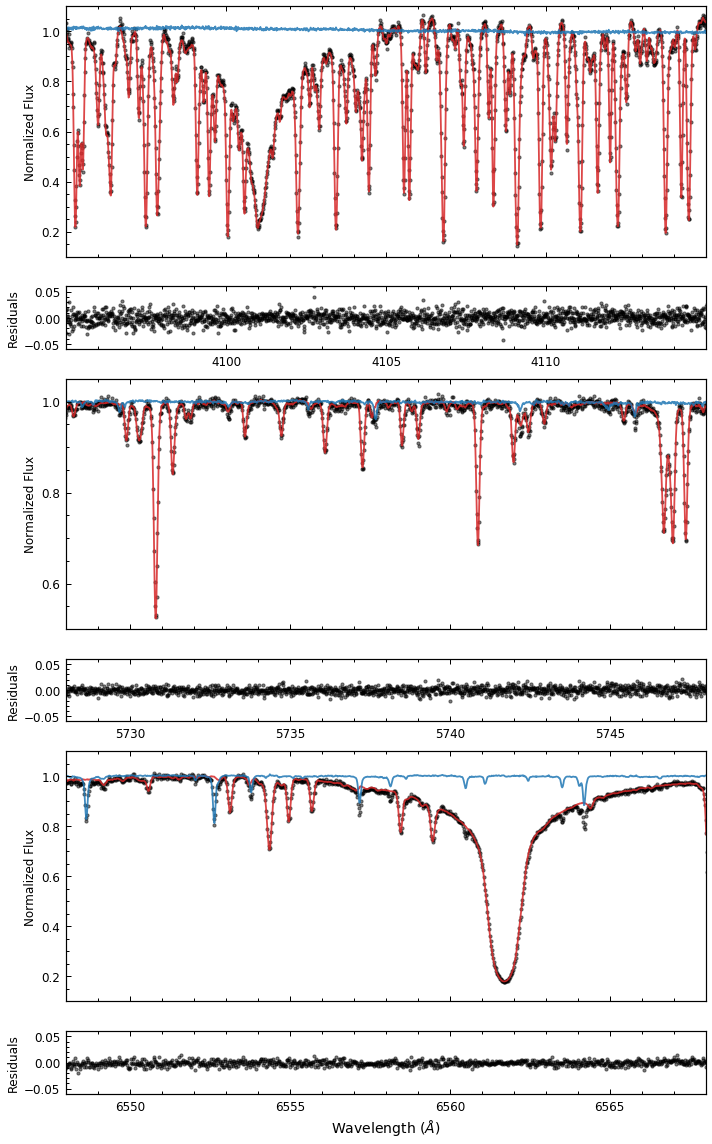

In [8]:
fig, axes = plt.subplots(6, 1, gridspec_kw = {'height_ratios':[4, 1, 4, 1, 4, 1]}, figsize=(10,16), sharex=False)
for i,r0 in enumerate(r):
    ax, ax2 = axes[2*i], axes[2*i+1]
    xs = np.ravel(np.exp(data_51peg.xs[i]))
    ys = np.ravel(np.exp(data_51peg.ys[i]))
    mask = np.ravel(data_51peg.ivars[i]) <= 1.e-8
    resids = ys - np.exp(results_51peg.star_ys_predicted[r0][n] 
                            + results_51peg.tellurics_ys_predicted[r0][n])
    ax.scatter(xs, ys, marker=".", alpha=0.5, c=DATA_COLOR, label='data', s=40)
    ax.scatter(xs[mask], ys[mask], marker=".", alpha=1., c='white', s=20)
    ax.plot(xs, np.exp(results_51peg.star_ys_predicted[r0][n]), 
                color=MODEL_STAR_COLOR, label='star model', lw=1.8, alpha=0.85)
    ax.plot(xs, np.exp(results_51peg.tellurics_ys_predicted[r0][n]), 
                color=MODEL_T_COLOR, label='tellurics model', lw=1.8, alpha=0.85)

    ax2.scatter(xs, resids, marker=".", alpha=0.5, c=DATA_COLOR, s=40)
    ax2.scatter(xs[mask], resids[mask], marker=".", alpha=1., c='white', s=20)
    

    if i == 1:
        ax.set_ylim([0.5,1.05])
        ax.set_yticks(np.arange(0.6,1.1,0.2))
        ax.set_yticks(np.arange(0.5,1.05,0.05), minor=True)
    else:
        ax.set_ylim([0.1,1.1])
        ax.set_yticks(np.arange(0.2,1.1,0.2))
        ax.set_yticks(np.arange(0.1,1.15,0.05), minor=True)
    ax.set_xlim([xstart[i],xend[i]])
    ax.set_xticks(np.arange(round(xstart[i] + 5,-1), xend[i], 5))
    ax.set_xticks(np.arange(xstart[i], xend[i]+1, 1), minor=True)
    #if i<2:
    ax2.set_ylim([-0.06, 0.06])
    ax2.set_yticks(np.arange(-0.05,0.06,0.05))
    ax2.set_yticks(np.arange(-0.06,0.06,0.01), minor=True)
    ax2.set_xlim([xstart[i],xend[i]])
    ax2.set_xticks(np.arange(round(xstart[i] + 5,-1), xend[i], 5))
    ax2.set_xticks(np.arange(xstart[i], xend[i]+1, 1), minor=True)
    ax.set_xticklabels('')
    ax.set_ylabel('Normalized Flux', fontsize=12)
    ax2.set_ylabel('Residuals', fontsize=12)
    
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
fig.tight_layout()
#fig.subplots_adjust(hspace=0.05)
plt.savefig('51peg_multispectrum.png')
plt.savefig('51peg_multispectrum.pdf')

### FIGURE: orbit fit

In [9]:
from numpy import log, exp, pi, sqrt, sin, cos, tan, arctan

def calc_ma(T0, t, period):
    # calculate mean anomaly
    days = t - T0
    phase = days/period % 1.0
    ma = phase * 2.0 * pi
    return ma
    
def calc_ea(ma, ecc):
    # calculate eccentric anomaly from mean anomaly, eccentricity
    tolerance = 1e-3
    ea = np.copy(ma)
    while True:
        diff = ea - ecc * sin(ea) - ma
        ea -= diff / (1. - ecc * cos(ea))
        if abs(diff).all() <= tolerance:
            break
    return ea
 
    
def calc_rvs(t,par):
    '''
    Calculate RV(t) given par
    par: [period, K, ecc, omega, M0, offset]
    where omega is the argument of periastron
    and Tp is time at periastron
    '''
    P,K,ecc,omega,tp,offset = par
    
    # enforce boundaries on parameters:
    #if (P < 0.0 or K < 0.0 or ecc < 0.0 or ecc > 0.999 or omega < 0. or omega > 2.*pi or M0 < 0. or M0 > 2.*pi):
    #    return np.zeros_like(t)
    #P = max([0.0, P])
    #K = max([0.0, K])
    #ecc = min([max([0.0, ecc]), 0.99])
    #omega = min([max([-pi, omega]), pi])
    #M0 = min([max([-pi, M0]), pi])
    
    ma = 2. * pi / P * (t - tp)  # mean anomaly
    ea = calc_ea(ma, ecc)  # eccentric anomaly

    f = 2.0 * np.arctan2(sqrt(1+ecc)*sin(ea/2.0), sqrt(1-ecc)*cos(ea/2.0)) # true anomaly
    rvs = - K * (cos(omega + f) + ecc*cos(omega))
    return rvs + offset

def calc_msini(P, K, ecc, Mstar=1.0):
    '''
    works in the limit that msini << Mstar
    takes:
    K - RV semi-amplitude in m/s
    P - period in days
    ecc - eccentricity (dimensionless)
    Mstar - host star mass in solar masses (default 1)
    returns:
    msini - minimum mass in Jupiters
    '''
    scaled_k = np.abs(K) / 28.4329 * np.sqrt(1. - ecc**2)
    msini = scaled_k * (P / 365.)**(1./3.) * Mstar**(2./3.)
    return msini

    
def keplerian(par,x):
    return calc_rvs(x, par)

def resid(par,fn,x,y,yerr):
    model = fn(par,x)
    return (y - model)/yerr 

In [10]:
rvs = results_51peg.star_time_rvs + results_51peg.bervs - results_51peg.drifts
pipeline_rvs = results_51peg.pipeline_rvs + results_51peg.bervs - results_51peg.drifts
sigs = results_51peg.star_time_sigmas
#pipeline_sigs = data_51peg.pipeline_sigmas
pipeline_sigs = np.ones_like(sigs) # HACK!!!!
dates = results_51peg.dates

In [35]:
import pymc3 as pm
import theano.tensor as tt

from exoplanet.orbits import get_true_anomaly
from exoplanet.distributions import Angle

t, rv, rv_err = dates, rvs, sigs

with pm.Model() as model:

    # Parameters
    logK = pm.Uniform("logK", lower=0, upper=np.log(200),
                      testval=np.log(0.5*(np.max(rv) - np.min(rv))))
    logP = pm.Uniform("logP", lower=0, upper=np.log(10),
                      testval=np.log(4.230785))
    phi = pm.Uniform("phi", lower=0, upper=2*np.pi, testval=0.2)
    e = pm.Uniform("e", lower=0, upper=1, testval=0.01)
    w = Angle("w")
    logjitter = pm.Uniform("logjitter", lower=-10, upper=5,
                           testval=np.log(np.mean(rv_err)))
    rv0 = pm.Normal("rv0", mu=0.0, sd=10.0, testval=np.median(rv))
    #rvtrend = pm.Normal("rvtrend", mu=0.0, sd=10.0, testval=0.0)

    # Deterministic transformations
    n = 2*np.pi*tt.exp(-logP)
    P = pm.Deterministic("P", tt.exp(logP))
    K = pm.Deterministic("K", tt.exp(logK))
    cosw = tt.cos(w)
    sinw = tt.sin(w)
    s2 = tt.exp(2*logjitter)
    t0 = (phi + w) / n

    # The RV model
    #bkg = pm.Deterministic("bkg", rv0 + rvtrend * t / 365.25)
    M = n * t - (phi + w)

    # This is the line that uses the custom Kepler solver
    f = get_true_anomaly(M, e + tt.zeros_like(M))
    rvmodel = pm.Deterministic(
        "rvmodel", rv0 + K * (cosw*(tt.cos(f) + e) - sinw*tt.sin(f)))

    # Condition on the observations
    pm.Normal("obs", mu=rvmodel, sd=rv_err, observed=rv)

    # Compute the phased RV signal
    phase = np.linspace(0, 1, 500)
    M_pred = 2*np.pi * phase - (phi + w)
    f_pred = get_true_anomaly(M_pred, e + tt.zeros_like(M_pred))
    rvphase = pm.Deterministic(
        "rvphase", K * (cosw*(tt.cos(f_pred) + e) - sinw*tt.sin(f_pred)))

In [36]:
with model:
    par_wobble = pm.find_MAP()

logp = -2.0824e+05, ||grad|| = 5.6126e+10: 100%|██████████| 20/20 [00:00<00:00, 396.35it/s]  


In [40]:
np.exp(par_wobble['logjitter'])

1.0966263741777076

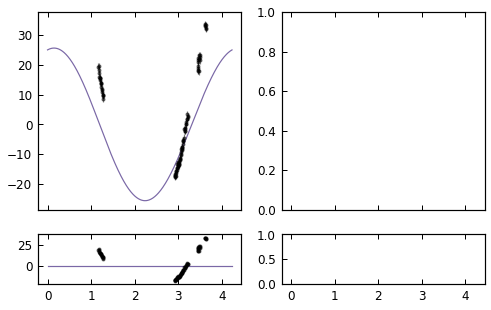

In [37]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, gridspec_kw = {'height_ratios':[4, 1]}, 
                                         figsize=(8,5), sharex=True)

ax1.errorbar(dates % par_wobble["P"], rvs - par_wobble['rv0'], 
             sigs, fmt='o', color=DATA_COLOR, alpha=0.5, ms=3)

ax1.plot(phase * par_wobble["P"], par_wobble['rvphase'], color=COLOR3)

ax3.errorbar(dates % par_wobble["P"], rvs - par_wobble['rv0'], sigs, fmt='o', 
             color=DATA_COLOR, alpha=0.5, ms=3)
ax3.plot(phase * par_wobble["P"], np.zeros_like(phase), color=COLOR3)

'''ax2.errorbar(dates, rvs - par_pipeline[-1], 
             pipeline_sigs, fmt='o', color=DATA_COLOR, alpha=0.5, ms=3)

xs = np.arange(-pipeline_offset-0.1,period_pipeline+pipeline_offset,0.1)
ax2.plot(xs + pipeline_offset, calc_rvs(xs, par_pipeline) - par_pipeline[-1], color=COLOR3)

ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=16)
ax1.set_ylim([-60,60])
ax2.set_ylim([-60,60])
ax3.set_ylim([-5, 5])
ax3.set_xlim([0,4.2])
ax4.set_ylim([-5, 5])
ax4.set_xlim([0,4.2])

resids = rvs - calc_rvs(dates, par_wobble)
resids_pipeline = pipeline_rvs - calc_rvs(dates, par_pipeline)



ax4.errorbar(date_fold_pipeline, resids_pipeline, pipeline_sigs, fmt='o', 
             color=DATA_COLOR, alpha=0.5, ms=3)
ax4.plot(xs, np.zeros_like(xs), color=COLOR3)


print('chisq = {0:.2f}'.format(np.sum(resids**2/sigs**2)))
print('resids RMS = {0:.2f} m/s'.format(np.std(resids)))
print('planet period = {0:.4f} days'.format(period_wobble))
print('planet msini = {0:.2f} MJup'.format(calc_msini(*par_wobble[:3])))
ax3.set_ylabel('Resids', fontsize=16)
ax3.set_xlabel('Phase-Folded Time (JD)', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(hspace=.05)
plt.savefig('51peg_planet.png')
plt.savefig('51peg_planet.pdf')
''';

## tellurics model 
#### (still using 51 Peg data)

### FIGURE: telluric basis vectors

In [ ]:
r = 63
xlim = [6275,6295]
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[1, 1]}, 
                               figsize=(8,5), sharex=True)
ax1.plot(np.exp(results_51peg.tellurics_template_xs[r]),
       np.exp(results_51peg.tellurics_template_ys[r]), c='k')
for k in range(results_51peg.tellurics_K[r]):
    ax2.plot(np.exp(results_51peg.tellurics_template_xs[r]), 
            np.exp(results_51peg.tellurics_basis_vectors[r][k]) - 0.005*k)
ax1.set_xlim(xlim)
ax1.set_ylim([0.65,1.05])
ax2.set_xlim(xlim)
ax1.set_ylabel('Template Spectrum', fontsize=14)
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
ax2.set_ylabel(r'Basis Vectors + $\Delta$', fontsize=14)
ax2.set_yticks(np.arange(0.990,1.005,0.005))
ax2.set_yticks(np.arange(0.987,1.005,0.001), minor=True)
ax2.set_xticks(np.arange(xlim[0],xlim[1]+1,5))
ax2.set_xticks(np.arange(xlim[0],xlim[1],1), minor=True)
fig.tight_layout()
fig.subplots_adjust(hspace=.05)
plt.savefig('telluric_basis.png')

In [ ]:
r = 56
xlim = [5880,5910]
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[1, 1]}, 
                               figsize=(8,5), sharex=True)
ax1.plot(np.exp(results_51peg.tellurics_template_xs[r]),
       np.exp(results_51peg.tellurics_template_ys[r]), c='k')
for k in range(results_51peg.tellurics_K[r]):
    ax2.plot(np.exp(results_51peg.tellurics_template_xs[r]), 
            np.exp(results_51peg.tellurics_basis_vectors[r][k]) - 0.1*k)
ax1.set_xlim(xlim)
ax1.set_ylim([0.9,1.02])
ax2.set_xlim(xlim)
ax1.set_ylabel('Template Spectrum', fontsize=14)
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
ax2.set_ylabel(r'Basis Vectors + $\Delta$', fontsize=14)
ax2.set_yticks(np.arange(0.7,1.1,0.1))
ax2.set_yticks(np.arange(0.7,1.1,0.02), minor=True)
ax2.set_xticks(np.arange(xlim[0],xlim[1]+1,5))
ax2.set_xticks(np.arange(xlim[0],xlim[1],1), minor=True)
fig.tight_layout()
fig.subplots_adjust(hspace=.05)
plt.savefig('telluric_basis2.png')
plt.savefig('telluric_basis2.pdf')

### FIGURE: telluric basis weights

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
jan1_2003 = 2452640.5
for k,ax in enumerate(axes):
    ax.plot((results_51peg.dates - jan1_2003) % 365., results_51peg.tellurics_basis_weights[r][:,k], 'k.')
    ax.set_xticks([152, 182, 213, 244, 274, 305])
    ax.set_xticklabels(['June', 'July', 'Aug', 'Sept', 'Oct', 'Nov'])
    ax.set_ylim([-0.8,0.4])

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for k,ax in enumerate(axes):
    ax.plot(results_51peg.dates - 2450000., results_51peg.tellurics_basis_weights[r][:,k], 'k.')
    #ax.set_xticks([152, 182, 213, 244, 274, 305])
    #ax.set_xticklabels(['June', 'July', 'Aug', 'Sept', 'Oct', 'Nov'])
    ax.set_ylim([-0.8,0.4])

### FIGURE: tellurics compared to standard star

In [ ]:
from wobble.utils import fit_continuum
from astropy.io import fits
r = 63
xlim = [6275,6295]

In [ ]:
spec_file = '/Users/mbedell/python/wobble/data/telluric/HARPS.2009-05-09T23:40:43.280_e2ds_A.fits'
wave_file = '/Users/mbedell/python/wobble/data/telluric/HARPS.2009-05-09T20:24:26.952_wave_A.fits'
sp = fits.open(spec_file)
flux = sp[0].data
sp2 = fits.open(wave_file)
wave = sp2[0].data
snr = sp[0].header['HIERARCH ESO DRS SPE EXT SN{0}'.format(str(int(r)))]
am = sp[0].header['AIRMASS']

In [ ]:
am

In [ ]:
o = 57
wave2,flux2 = np.exp(results_51peg.tellurics_template_xs[r]), \
              np.exp(results_51peg.tellurics_template_ys[r] * am)
wave1,flux1 = wave[r][:1500], flux[r][:1500] # HACK
ivars1 = np.zeros_like(flux1) + snr**2 # HACK
flux1 = np.exp(np.log(flux1) - fit_continuum(np.log(wave1), np.log(flux1), ivars1))

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[1, 1]}, 
                               figsize=(8,5), sharex=True)
ax2.plot(wave1,flux1+0.012,color=DATA_COLOR,alpha=0.6,label='telluric standard star')
ax1.plot(wave2,flux2,color=MODEL_T_COLOR,alpha=0.9,label='wobble telluric model')
ax2.set_xlim(xlim)
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=16)
ax1.set_ylabel(' ', fontsize=16) # hack to leave space for shared label
ax1.legend(loc='lower right', fontsize=14)
ax2.legend(loc='lower right', fontsize=14)
ax2.set_xticks(np.arange(xlim[0],xlim[1]+1,5))
ax2.set_xticks(np.arange(xlim[0],xlim[1],1), minor=True)
ax1.set_ylim([0.58,1.05])
ax2.set_ylim([0.58,1.05])
fig.text(0.01, 0.6, 'Normalized Flux', fontsize=16, rotation=90, verticalalignment='center')
fig.tight_layout()
fig.subplots_adjust(hspace=.05)
fig.savefig('telluric_standard.png')
fig.savefig('telluric_standard.pdf')

## quiet M star:

In [ ]:
results_barnards = wobble.Results(filename='/Users/mbedell/python/wobble/results/results_barnards_Kstar0_Kt0.hdf5')

### FIGURE: data and models for random epoch

In [ ]:
o = [12,53,67]
r = np.arange(63)[np.isin(results_barnards.orders,o)] # index into results to get desired orders
e = 54 # epoch
n = np.where(results_barnards.epochs == e)[0][0] # index into results to get desired epoch

data_barnards = wobble.Data('barnards_e2ds.hdf5', filepath='/Users/mbedell/python/wobble/data/', 
                   orders=o, epochs=[e])

xs = np.exp(data_barnards.xs)
ys = np.exp(data_barnards.ys)
mask = np.array(data_barnards.ivars) <= 1.e-8

In [ ]:
xstart = [4095, 5728, 6548]
xend = [4115, 5748, 6568]

In [ ]:
fig, axes = plt.subplots(6, 1, gridspec_kw = {'height_ratios':[4, 1, 4, 1, 4, 1]}, figsize=(10,16), sharex=False)
for i,r0 in enumerate(r):
    ax, ax2 = axes[2*i], axes[2*i+1]
    xs = np.ravel(np.exp(data_barnards.xs[i]))
    ys = np.ravel(np.exp(data_barnards.ys[i]))
    mask = np.ravel(data_barnards.ivars[i]) <= 1.e-8
    resids = ys - np.exp(results_barnards.star_ys_predicted[r0][n] 
                            + results_barnards.tellurics_ys_predicted[r0][n])
    ax.scatter(xs, ys, marker=".", alpha=0.5, c=DATA_COLOR, label='data', s=40)
    ax.scatter(xs[mask], ys[mask], marker=".", alpha=1., c='white', s=20)
    ax.plot(xs, np.exp(results_barnards.star_ys_predicted[r0][n]), 
                color=MODEL_STAR_COLOR, label='star model', lw=1.8, alpha=0.85)
    ax.plot(xs, np.exp(results_barnards.tellurics_ys_predicted[r0][n]), 
                color=MODEL_T_COLOR, label='tellurics model', lw=1.8, alpha=0.85)

    ax2.scatter(xs, resids, marker=".", alpha=0.5, c=DATA_COLOR, s=40)
    ax2.scatter(xs[mask], resids[mask], marker=".", alpha=1., c='white', s=20)
    

    
    ax.set_ylim([0.35,1.15])
    ax.set_yticks(np.arange(0.4,1.2,0.1))
    ax.set_yticks(np.arange(0.35,1.2,0.05), minor=True)
    if i==1:
        ax.set_ylim([0.4,1.25])
        ax.set_yticks(np.arange(0.4,1.4,0.2))
        ax.set_yticks(np.arange(0.4,1.2,0.05), minor=True)        
    if i==0:
        ax.set_ylim([0.0,1.25])
        ax.set_yticks(np.arange(0.0,1.4,0.2))
        ax.set_yticks(np.arange(0.0,1.2,0.05), minor=True)
    ax.set_xlim([xstart[i],xend[i]])
    ax.set_xticks(np.arange(round(xstart[i] + 5,-1), xend[i], 5))
    ax.set_xticks(np.arange(xstart[i], xend[i]+1, 1), minor=True)
    ax2.set_ylim([-0.07, 0.07])
    ax2.set_yticks(np.arange(-0.05,0.06,0.05))
    ax2.set_yticks(np.arange(-0.07,0.08,0.01), minor=True)
    if i==0:
        ax2.set_ylim([-0.5, 0.5])
        ax2.set_yticks(np.arange(-0.4,0.5,0.2))
        ax2.set_yticks(np.arange(-0.5,0.5,0.1), minor=True)
    ax2.set_xlim([xstart[i],xend[i]])
    ax2.set_xticks(np.arange(round(xstart[i] + 5,-1), xend[i], 10))
    ax2.set_xticks(np.arange(xstart[i], xend[i]+1, 1), minor=True)
    ax.set_xticklabels('')
    ax.set_ylabel('Normalized Flux', fontsize=12)
    ax2.set_ylabel('Residuals', fontsize=12)
    
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
fig.tight_layout()
#fig.subplots_adjust(hspace=0.05)
plt.savefig('barnards_multispectrum.png')
plt.savefig('barnards_multispectrum.pdf')

### FIGURE: tellurics zoom-in

In [ ]:
o = 63 # order
r = np.where(results_barnards.orders == o)[0][0] # index into results to get desired order
e = 20 # epoch
n = np.where(results_barnards.epochs == e)[0][0] # index into results to get desired epoch

data_barnards = wobble.Data('barnards_e2ds.hdf5', filepath='/Users/mbedell/python/wobble/data/', 
                   orders=[o], epochs=[e])

xs_barnards = np.exp(data_barnards.xs[0][0])
ys_barnards = np.exp(data_barnards.ys[0][0])
mask_barnards = data_barnards.ivars[0][0] <= 1.e-8
predicted_barnards = np.exp(results_barnards.star_ys_predicted[r][n] 
                            + results_barnards.tellurics_ys_predicted[r][n])
resids_barnards = ys_barnards - predicted_barnards

In [ ]:
data_barnards = wobble.Data('barnards_e2ds.hdf5', filepath='/Users/mbedell/python/wobble/data/', 
                   orders=[o])
print(results_barnards.epochs[results_barnards.airms > 1.6])

In [ ]:
print(results_barnards.airms[n])

In [ ]:
o = 63 # order
r1 = np.where(results_51peg.orders == o)[0][0] # index into results to get desired order
e = 41 # epoch
n1 = np.where(results_51peg.epochs == e)[0][0] # index into results to get desired epoch

data_51peg = wobble.Data('51peg_e2ds.hdf5', filepath='/Users/mbedell/python/wobble/data/', 
                   orders=[o], epochs=[e])

xs_51peg = np.exp(data_51peg.xs[0][0])
ys_51peg = np.exp(data_51peg.ys[0][0])
mask_51peg = data_51peg.ivars[0][0] <= 1.e-8
predicted_51peg = np.exp(results_51peg.star_ys_predicted[r1][n1] 
                            + results_51peg.tellurics_ys_predicted[r1][n1])
resids_51peg = ys_51peg - predicted_51peg

In [ ]:
print(results_51peg.airms[n1])

In [ ]:
fig, ((ax,ax3), (ax2,ax4)) = plt.subplots(2, 2, gridspec_kw = {'height_ratios':[4, 1]}, figsize=(12,5), sharex=True)

ax.scatter(xs_51peg, ys_51peg, marker=".", alpha=0.5, c=DATA_COLOR, label='data', s=40)
ax.scatter(xs_51peg[mask_51peg], ys_51peg[mask_51peg], marker=".", alpha=1., c='white', s=20)
ax.plot(xs_51peg, predicted_51peg, lw=1.5, alpha=0.7, color='k')
ax.plot(xs_51peg, np.exp(results_51peg.star_ys_predicted[r1][n1]) + 0.6, 
                color=MODEL_STAR_COLOR, label='star model', lw=1.5, alpha=0.8)
ax.plot(xs_51peg, np.exp(results_51peg.tellurics_ys_predicted[r1][n1]) + 1., 
                color=MODEL_T_COLOR, label='tellurics model', lw=2.5, alpha=0.8)
ax.set_ylabel('Normalized Flux + const.', fontsize=14, labelpad=20)

ax2.scatter(xs_51peg, resids_51peg, marker=".", alpha=0.5, c=DATA_COLOR, s=40)
ax2.scatter(xs_51peg[mask_51peg], resids_51peg[mask_51peg], marker=".", alpha=1., c='white', s=20)
ax2.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
ax2.set_ylabel('Residuals', fontsize=14)

ax3.scatter(xs_barnards, ys_barnards, marker=".", alpha=0.5, c=DATA_COLOR, label='data', s=40)
ax3.scatter(xs_barnards[mask_barnards], ys_barnards[mask_barnards], marker=".", alpha=1., c='white', s=20)
ax3.plot(xs_barnards, predicted_barnards, lw=1.5, alpha=0.7, color='k')
ax3.plot(xs_barnards, np.exp(results_barnards.star_ys_predicted[r][n]) + 0.6, 
                color=MODEL_STAR_COLOR, label='star model', lw=1.5, alpha=0.8)
ax3.plot(xs_barnards, np.exp(results_barnards.tellurics_ys_predicted[r][n]) + 1., 
                color=MODEL_T_COLOR, label='tellurics model', lw=2.5, alpha=0.8)

ax4.scatter(xs_barnards, resids_barnards, marker=".", alpha=0.5, c=DATA_COLOR, s=40)
ax4.scatter(xs_barnards[mask_barnards], resids_barnards[mask_barnards], marker=".", alpha=1., c='white', s=20)
ax4.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)

ax.set_ylim([0.25,2.2])
ax.set_yticks(np.arange(0.4,2.1,0.2))
ax.set_yticks(np.arange(0.25,2.2,0.05), minor=True)
ax3.set_ylim([0.25,2.2])
ax3.set_yticks(np.arange(0.4,2.1,0.2))
ax3.set_yticks(np.arange(0.25,2.2,0.05), minor=True)
ax3.set_yticklabels('')

ax2.set_ylim([-0.06, 0.06])
ax2.set_yticks(np.arange(-0.05,0.06,0.05))
ax2.set_yticks(np.arange(-0.06,0.06,0.01), minor=True)
ax4.set_ylim([-0.06, 0.06])
ax4.set_yticks(np.arange(-0.05,0.06,0.05))
ax4.set_yticks(np.arange(-0.06,0.06,0.01), minor=True)
ax4.set_yticklabels('')


ax.set_xlim([6301,6315.5])
ax.set_xticks(np.arange(6302, 6315, 2))
ax.set_xticks(np.arange(6301, 6316, 0.5), minor=True)

ax.text(6303, 2.05, 'tellurics model', fontsize=12)
ax.text(6303, 1.65, 'star model', fontsize=12)
ax.text(6303, 1.05, 'data & composite model', fontsize=12)
ax.set_title('51 Peg', fontsize=14)
ax3.set_title('Barnard\'s Star', fontsize=14)

#ax.legend(fontsize=12)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05, wspace=0.02)
plt.savefig('telluric_comparison.png')
plt.savefig('telluric_comparison.pdf')

### FIGURE: comparison to PHOENIX model

In [ ]:
from astropy.io import fits
#hdul = fits.open('/Users/mbedell/python/wobble/data/lte03300-5.00-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#model_ys_3300k = np.copy(hdul[0].data)
hdul = fits.open('/Users/mbedell/python/wobble/data/lte03200-5.00-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
model_ys_3200k = np.copy(hdul[0].data)
#hdul = fits.open('/Users/mbedell/python/wobble/data/lte03200-5.50-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#model_ys_55logg = np.copy(hdul[0].data)
#hdul = fits.open('/Users/mbedell/python/wobble/data/lte03200-4.50-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#model_ys_45logg = np.copy(hdul[0].data)
#hdul = fits.open('/Users/mbedell/python/wobble/data/lte03200-4.00-0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
#model_ys_40logg = np.copy(hdul[0].data)
hdul = fits.open('/Users/mbedell/python/wobble/data/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
model_xs = np.copy(hdul[0].data)

In [ ]:
o = 24 # order
r = np.where(results_barnards.orders == o)[0][0] # index into results to get desired order
e = 216 # epoch
n = np.where(results_barnards.epochs == e)[0][0] # index into results to get desired epoch

data_barnards = wobble.Data('barnards_e2ds.hdf5', filepath='/Users/mbedell/python/wobble/data/', 
                   orders=[o], epochs=[e])

xs = np.exp(data_barnards.xs[0][0])
ys = np.exp(data_barnards.ys[0][0])
mask = data_barnards.ivars[0][0] <= 1.e-8
resids = ys - np.exp(results_barnards.star_ys_predicted[r][n] 
                            + results_barnards.tellurics_ys_predicted[r][n])

In [ ]:
v_sys = 219.e3 # from eyeballing the Balmer region (4020-4050A)

In [ ]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.plot(xs / doppler(v_sys), ys, 'k.', ms=5, alpha=0.6, label='data')
ax.plot(model_xs, model_ys_3200k/0.75e13, c=COLOR3, lw=1.5, alpha=0.9, label='PHOENIX model')
ax.plot(xs / doppler(v_sys), np.exp(results_barnards.star_ys_predicted[r][n]), 
                color=MODEL_STAR_COLOR, lw=1.5, alpha=0.9, label='wobble star model')
ax.set_xlim([4450,4465])


ax.set_xticks(np.arange(4450, 4466, 5))
ax.set_xticks(np.arange(4450, 4465, 0.5), minor=True)
ax.set_ylim([-0.02,1.4])
ax.set_yticks(np.arange(0.0,1.6,0.2))
ax.set_yticks(np.arange(0.0,1.5,0.05), minor=True)
ax.legend(fontsize=14)

ax.set_xlabel(r'Wavelength ($\AA$)', fontsize=14)
ax.set_ylabel('Normalized Flux', fontsize=14);
plt.savefig('barnards_model.png')
plt.savefig('barnards_model.pdf');

### FIGURE: time series

In [ ]:
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.time import Time

coord = SkyCoord(ra=269.4486, dec=4.7379807, unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(0.01, u.degree)
height = u.Quantity(0.01, u.degree)
r = Gaia.query_object_async(coordinate=coord, width=width, height=height)
star = r[r['source_id'] == 4472832130942575872]
rv_gaia = -110.51 * u.km / u.s # from Gaia DR2 docs

In [ ]:
pm = np.sqrt(star['pmra'][0]**2 + star['pmdec'][0]**2)
pm = (pm * u.mas / u.yr).to(u.arcsec / u.yr)
dist = (1./star['parallax'][0] * u.kpc).to(u.pc)
vt = (4.74 * dist * pm).value * u.km / u.s # decompose doesn't work here
min_dist = dist/np.sqrt(1. + rv_gaia**2/vt**2)
v = np.sqrt(rv_gaia**2 + vt**2)
obstime = Time(star['ref_epoch'][0], format='decimalyear')
min_dist_time = obstime + np.sqrt(dist**2 - min_dist**2)/v

In [ ]:
def predict_rv(date):
    t = (date - min_dist_time).jd * u.day # now relative to time of closest approach
    x = v**2 * t/np.sqrt(v**2 * t**2 + min_dist**2)
    return x.to(u.m / u.s)

In [ ]:
predicted_rvs = np.array([predict_rv(d).value for d in Time(results_barnards.dates, format='jd')])
post_upgrade = results_barnards.dates >= 2457174.5 # June 2015
pre_upgrade = results_barnards.dates < 2457174.5

In [ ]:
data_barnards = wobble.Data(results_barnards.origin_file, filepath='/Users/mbedell/python/wobble/', 
                   orders=[o], min_snr=0.)

In [ ]:
np.argmax(np.nanpercentile(data_barnards.ivars[0], 99, axis=1))

In [ ]:
rvs = results_barnards.star_time_rvs + results_barnards.bervs - data_barnards.drifts
pipeline_rvs = results_barnards.pipeline_rvs + results_barnards.bervs - data_barnards.drifts
sigs = results_barnards.star_time_sigmas

wobble_resids = rvs[pre_upgrade] - predicted_rvs[pre_upgrade]
wobble_resids -= np.median(wobble_resids)
pipeline_resids = pipeline_rvs[pre_upgrade] - predicted_rvs[pre_upgrade]
pipeline_resids -= np.median(pipeline_resids)

wobble_resids_post = rvs[post_upgrade] - predicted_rvs[post_upgrade]
wobble_resids_post -= np.median(wobble_resids_post)
pipeline_resids_post = pipeline_rvs[post_upgrade] - predicted_rvs[post_upgrade]
pipeline_resids_post -= np.median(pipeline_resids_post)

In [ ]:
fig, (ax, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[3, 1]}, figsize=(8,6))
ax.plot(results_barnards.dates[pre_upgrade], predicted_rvs[pre_upgrade] - np.mean(predicted_rvs[pre_upgrade]), 
        c=MODEL_T_COLOR, alpha=0.6, label='predicted RV')
ax.errorbar(results_barnards.dates[pre_upgrade], pipeline_rvs[pre_upgrade] - np.mean(pipeline_rvs[pre_upgrade]), 
             sigs[pre_upgrade], fmt='s', color=COLOR3, alpha=0.8, ms=5, elinewidth=1, label='HARPS pipeline')
ax.errorbar(results_barnards.dates[pre_upgrade], rvs[pre_upgrade] - np.mean(rvs[pre_upgrade]), 
             sigs[pre_upgrade], fmt='o', color=DATA_COLOR, alpha=0.8, ms=5, elinewidth=1, label='wobble')
ax.set_ylabel(r'RV (m s$^{-1}$)', fontsize=16)
ax.set_xticklabels([])

ax2.axhline(0.0, c=MODEL_T_COLOR)
ax2.errorbar(results_barnards.dates[pre_upgrade] - 2450000, pipeline_resids, 
             sigs[pre_upgrade], fmt='s', color=COLOR3, alpha=0.8, ms=5, elinewidth=1)
ax2.errorbar(results_barnards.dates[pre_upgrade] - 2450000, wobble_resids, 
             sigs[pre_upgrade], fmt='o', color=DATA_COLOR, alpha=0.8, ms=5, elinewidth=1)

ax2.set_xlabel('MJD', fontsize=16)
ax2.set_ylabel('Residuals', fontsize=16)

ax.legend(fontsize=14)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)
plt.savefig('barnards_rvs.png')
plt.savefig('barnards_rvs.pdf');

In [ ]:
np.std(pipeline_resids), np.std(pipeline_resids_post)

In [ ]:
np.std(wobble_resids), np.std(wobble_resids_post)

In [ ]:
len(wobble_resids), len(wobble_resids_post)

In [ ]:
pre_terra = results_barnards.dates < 2456067.5
np.std(results_barnards.pipeline_rvs[pre_terra] + results_barnards.bervs[pre_terra] 
       - predicted_rvs[pre_terra] - data_barnards.drifts[pre_terra])

## Rossiter-McLaughlin effect

In [ ]:
results_hd189 = wobble.Results(filename='/Users/mbedell/python/wobble/results/results_HD189733_Kstar0_Kt0.hdf5')

In [ ]:
results_hd189.combine_orders('star')

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[4, 1]}, figsize=(8,5), sharex=True)

offset = np.mean(results_hd189.star_time_rvs + results_hd189.bervs)
ax1.errorbar(results_hd189.dates - 2454341.5, results_hd189.star_time_rvs + results_hd189.bervs - offset, results_hd189.star_time_sigmas, 
             fmt='o', c='k', ms=4)

ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=16)

ax2.set_ylabel('Resids', fontsize=16)
ax2.set_xlabel('BJD - 2454341.5', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(hspace=.05)
plt.savefig('hd189_rm.png')
plt.savefig('hd189_rm.pdf')